# General information

Dataset used for the purpose of the following analysis was derived from an individual collection of insurance policies for civil liability used in the works of K.C.H.Yip and K.K.W. Yau from 2005, and Mathew Flynn and Louise A. Francis from 2009. Dataset includes 10,296 records, which are described by 33 variables of different type.

# Loading necessary libraries

In [1]:
install.packages("RColorBrewer")
install.packages("dummies")
install.packages("ROCR")
install.packages("pROC")
library(ggplot2)
library(RColorBrewer)
library(dummies)
library(corrplot)
library(repr)
library(caTools)
library(ROCR)
library(pROC)

Installing package into '/home/nbcommon/R'
(as 'lib' is unspecified)
Installing package into '/home/nbcommon/R'
(as 'lib' is unspecified)
Installing package into '/home/nbcommon/R'
(as 'lib' is unspecified)
Installing package into '/home/nbcommon/R'
(as 'lib' is unspecified)
dummies-1.5.6 provided by Decision Patterns

Loading required package: gplots

Attaching package: 'gplots'

The following object is masked from 'package:stats':

    lowess

Type 'citation("pROC")' for a citation.

Attaching package: 'pROC'

The following objects are masked from 'package:stats':

    cov, smooth, var



# Loading data and looking into the dataset

In [2]:
# Reading data from the csv file contatining all 33 variables

data <- read.csv('dane.csv')


# Choosing desired variables from the initial dataset

final <- data[,c('CLM_FREQ','AGE.GENDER','DENSITY','TRAVTIME','KIDSDRIV','CAR_USE', 'RED_CAR','MARRIED','INCOME','MVR_PTS','CAR_TYPE', 'MAX_EDUC')]
final$MAX_EDUC <- factor(gsub("<","",final$MAX_EDUC))
final$INCOME <- gsub("\\$","",final$INCOME)
final$INCOME <- as.numeric(final$INCOME)

# Since our Income variable contains over 500 NaN values, we are going to perfom an imputation using median 

final$INCOME[is.na(final$INCOME)] <- median(final$INCOME, na.rm = TRUE)

Let's take a look at the structure of our dataset 

In [3]:
str(final)

'data.frame':	10296 obs. of  12 variables:
 $ CLM_FREQ  : int  0 0 2 0 2 0 0 0 2 0 ...
 $ AGE.GENDER: Factor w/ 8 levels "16-24F","16-24M",..: 6 4 6 5 5 3 5 5 5 5 ...
 $ DENSITY   : Factor w/ 4 levels "Highly Rural",..: 2 4 4 3 4 4 2 2 2 2 ...
 $ TRAVTIME  : int  17 18 47 31 14 46 9 6 6 6 ...
 $ KIDSDRIV  : int  0 0 0 0 0 0 1 0 0 0 ...
 $ CAR_USE   : Factor w/ 2 levels "Commercial","Private": 2 2 1 2 1 2 1 2 1 2 ...
 $ RED_CAR   : Factor w/ 2 levels "no","yes": 2 2 2 1 1 1 1 1 1 1 ...
 $ MARRIED   : Factor w/ 2 levels "No","Yes": 2 1 1 2 2 2 1 1 1 1 ...
 $ INCOME    : num  53564 4457 102904 14554 99493 ...
 $ MVR_PTS   : int  0 4 0 0 2 0 8 0 0 2 ...
 $ CAR_TYPE  : Factor w/ 6 levels "Panel Truck",..: 2 4 1 3 2 3 6 4 2 3 ...
 $ MAX_EDUC  : Factor w/ 4 levels "Bachelors","High School",..: 2 2 3 2 2 1 4 4 4 4 ...


The predicted variable CLM_FREQ stands for the occurrence of the claim phenomenon by individual insured drivers within last 5 years, where i = 1, ..., 10296. The set of explanatory variables that I've chosen includes:

- AGE.GENDER -> interdependent variable age*gender
- DENSITY -> variable determining population density (rural, urban)
- TRAVTIME -> commuting time
- KIDSDRIV -> number of children on board 
- CAR_USE -> variable determining whether the car was used for private or commercial purposes
- RED_CAR -> variable determining whether the car colour was red 
- MARRIED -> marital status
- INCOME -> policyholder income
- MVR_PTS - Motor Vehicle Points
- CAR_TYPE -> type of car
- MAX_EDUC -> policyholder's education level

# Data visualization

It's time to visualize our data to find out something new about chosen features. We want to see:

- distribution of our variables
- interactions between single features and the target variable(CLM_FREQ)
- correllation heat-map

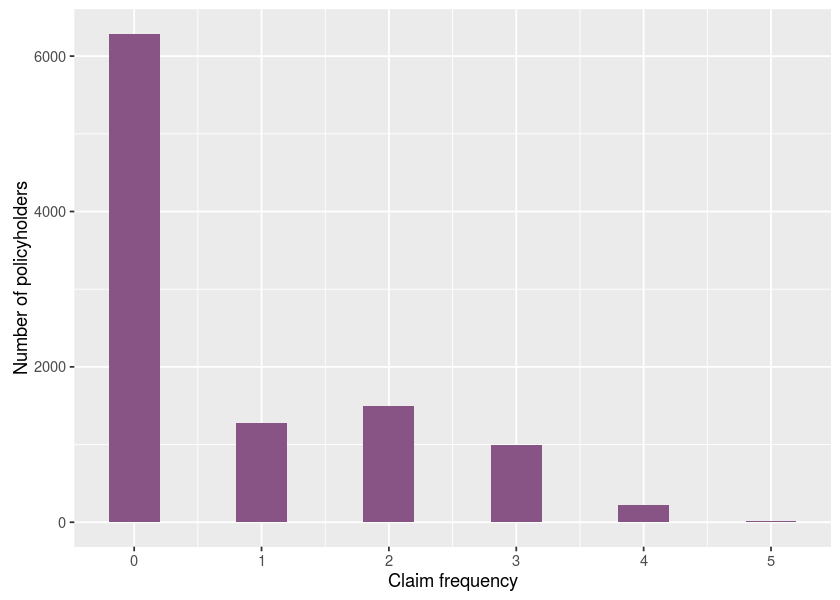

In [36]:
# Change plot size to 7 x 4
options(repr.plot.width=7, repr.plot.height=5)


ggplot(data=final, aes(CLM_FREQ)) +
geom_bar(width = 0.4, fill="#885486") +
labs(x="Claim frequency", y="Number of policyholders")+
scale_x_continuous(breaks=c(0,1,2,3,4,5))


As we can see on the above bar plot, it's more likely not to receive a claim from a customer than to receive it, so in the further stage we will create a binary variable for claims to denote whether there was a claim or not instead of predicting the exact number of claims. 

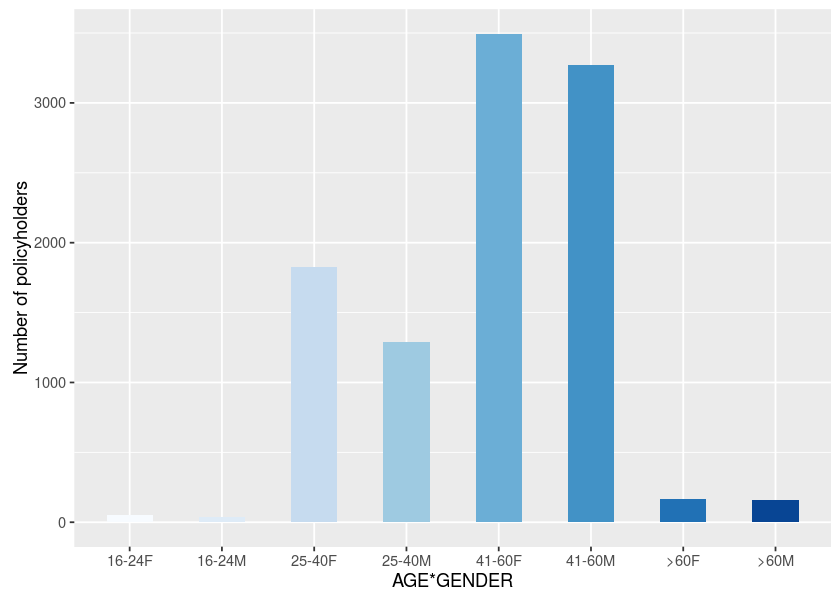

In [5]:
ggplot(data=final, aes(AGE.GENDER, fill=AGE.GENDER)) +
geom_bar(width = 0.5,show.legend=F) +
labs(x="AGE*GENDER", y="Number of policyholders") +
scale_fill_brewer()

The majority of our policyholders are males and females between 41 and 60 years. They represent over 65% of our sample.

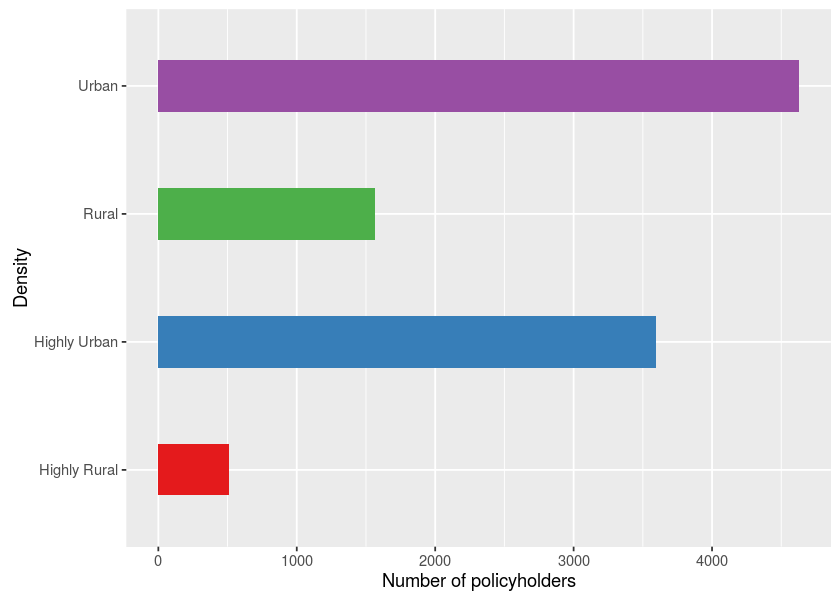

In [6]:
ggplot(data=final, aes(DENSITY, fill=DENSITY)) +
geom_bar(width = 0.4,show.legend=F) +
labs(x="Density", y="Number of policyholders") +
scale_fill_brewer(palette="Set1") +
coord_flip()



Also, the vast majority of our observations is represented by citizens of big cities. They pertain to about 80% of our population. 

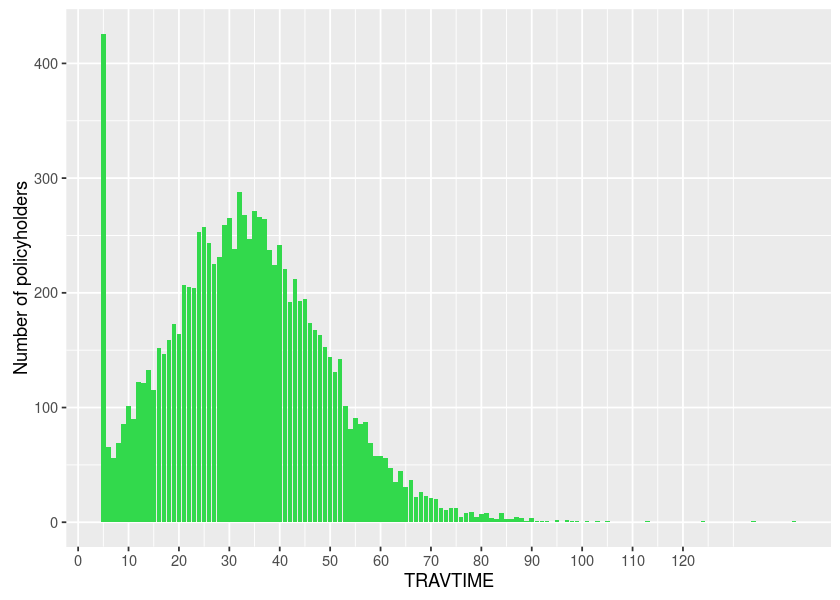

In [7]:
ggplot(data=final, aes(TRAVTIME)) +
geom_bar(fill="#32D94C")+
labs(y="Number of policyholders")+
scale_x_continuous(breaks=c(0,10,20,30,40,50,60,70,80,90,100,110,120))

As we can see, over 50% of the poliholders spends less than 35 minutes on their way to work. 

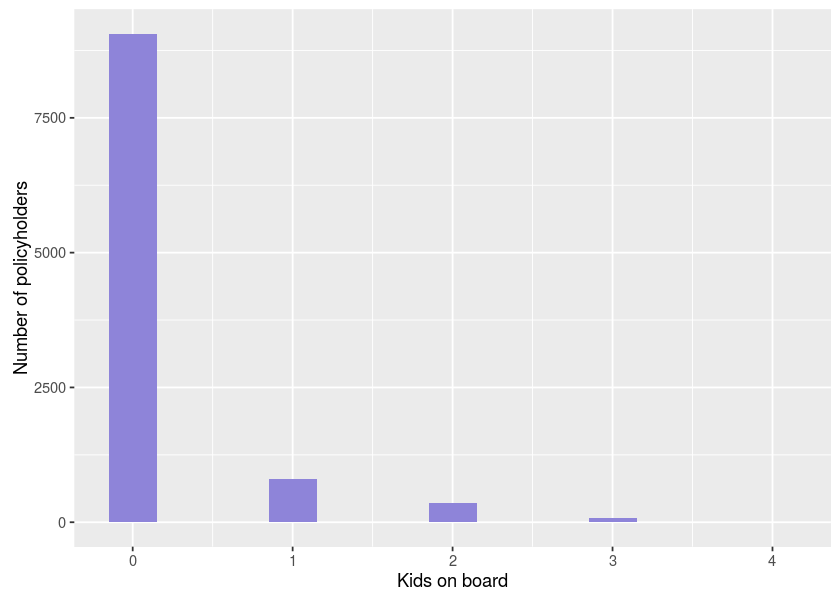

In [8]:
ggplot(data=final, aes(KIDSDRIV)) +
geom_bar(width = 0.3,fill="#8E84D9") +
labs(x="Kids on board", y="Number of policyholders")+
scale_x_continuous(breaks=c(0,1,2,3,4,5))


The majority of our drivers commutes without kids on board.

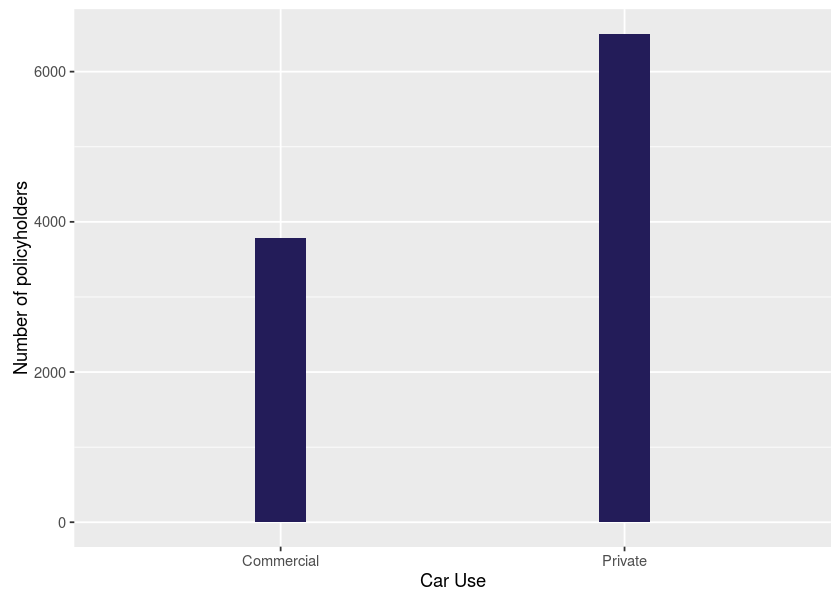

In [9]:
ggplot(data=final, aes(CAR_USE)) +
geom_bar(width = 0.15,fill="#231C59") +
labs(x="Car Use", y="Number of policyholders")

Most of our claims were submitted by policyholders who use their car for private purposes.

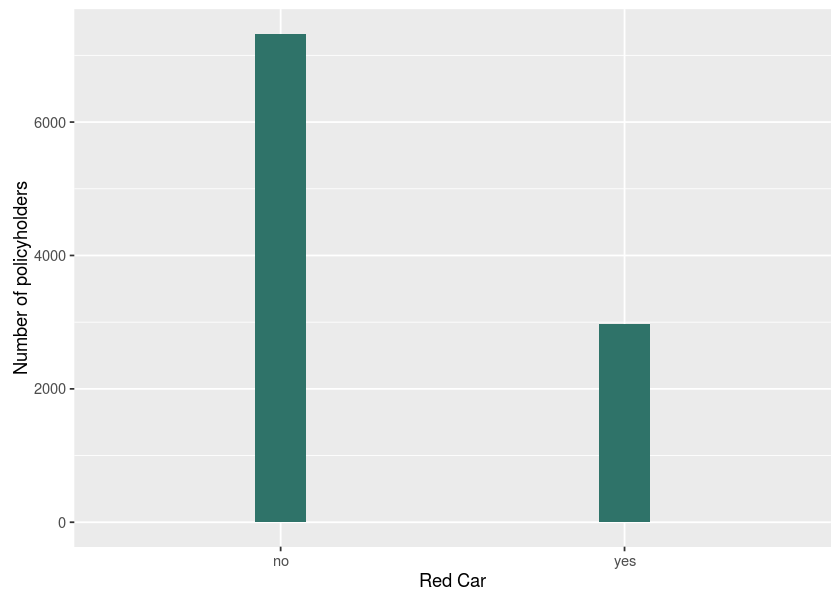

In [10]:
ggplot(data=final, aes(RED_CAR)) +
geom_bar(width = 0.15,fill="#2F7369") +
labs(x="Red Car", y="Number of policyholders")


Over 60% of claims were submitted by policyholders whose cars are not red.  

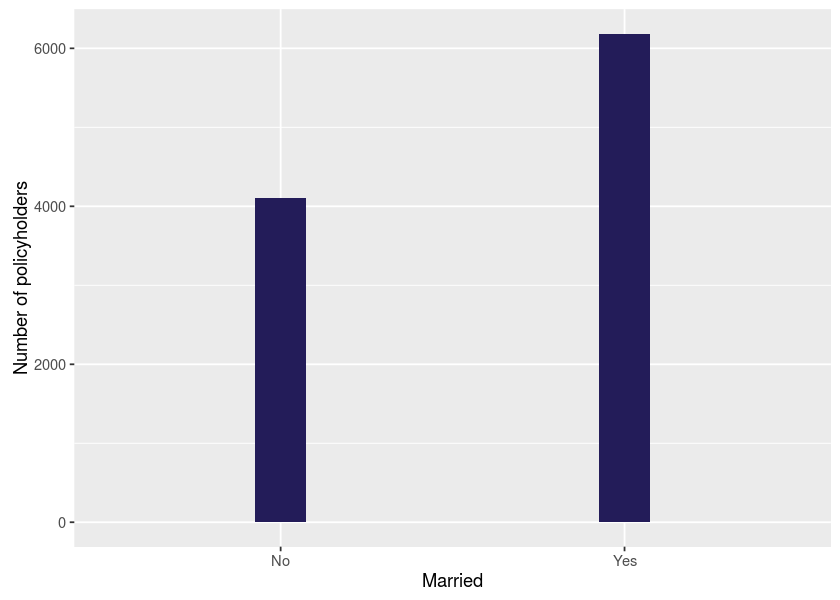

In [11]:
ggplot(data=final, aes(MARRIED)) +
geom_bar(width = 0.15,fill="#231C59") +
labs(x="Married", y="Number of policyholders")

Over 60 % of our policyholders are married.

Before plotting the income variable, I will split this continuous variable into some categories. To derive some ideas on how to split it, I'll print the summary statistics.

In [12]:
summary(final$INCOME)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0   29250   53560   61170   83300  367000 

In [13]:
final$IncomeCat<-cut(final$INCOME, c(29250,53560,83300,367000))

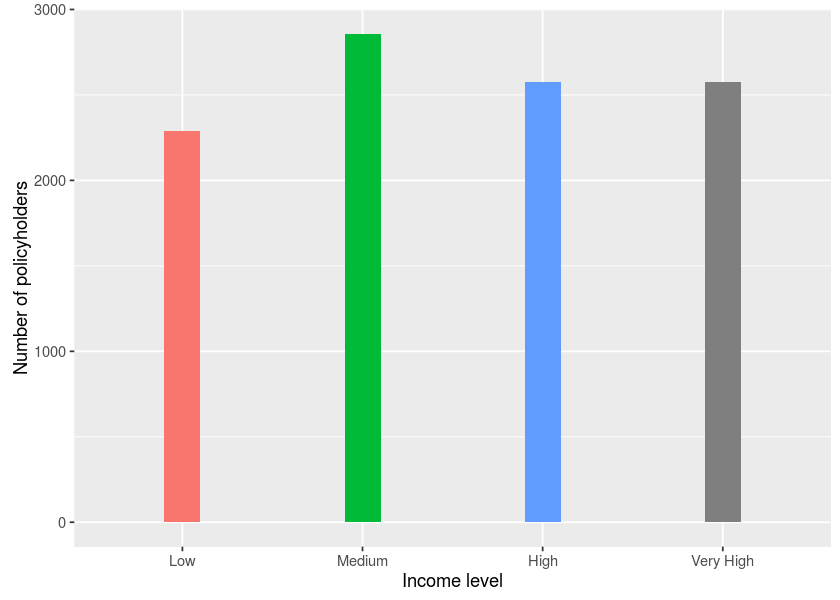

In [14]:
ggplot(data=final, aes(IncomeCat, fill=IncomeCat)) +
geom_bar(width = 0.2,show.legend=F) +
labs(x="Income level", y="Number of policyholders") +
scale_x_discrete(labels=c("Low","Medium","High", "Very High"))

According to our summary statics and the above bar plot, 50% of our policyholders earns 53560 dollars yearly or less, 75 percent earns up to 83300 dollars yearly and remunerations of the remaining 25 percent fall in between 83300 and 367000 dollars. 

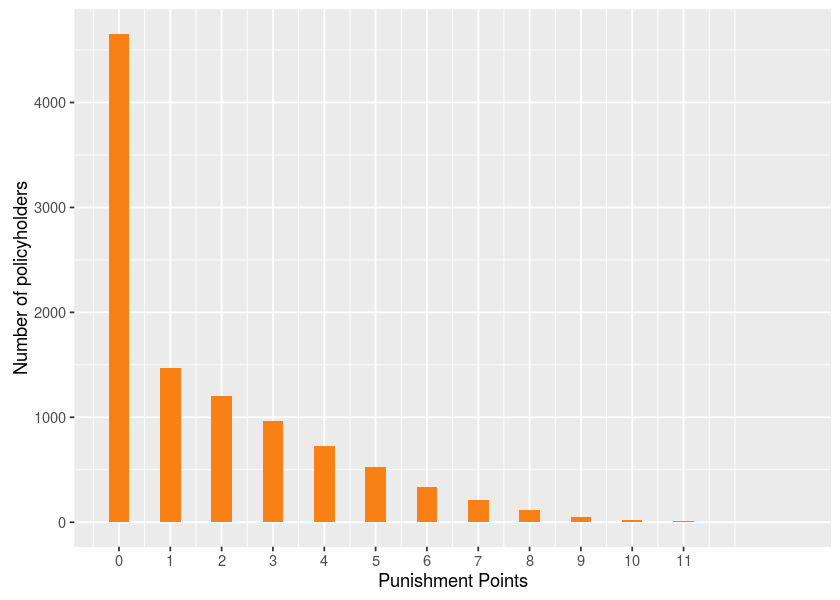

In [37]:
ggplot(data=final, aes(MVR_PTS)) +
geom_bar(width = 0.4,show.legend=F, fill="#F88015") +
labs(x="Punishment points", y="Number of policyholders")+
scale_x_continuous(breaks=c(0,1,2,3,4,5,6,7,8,9,10,11))

Nearly half of our population does not have any punishment points, we can assume that claims were submitted by the 
the remaining group of policyholders whose number of points falls in between 1 and 11.

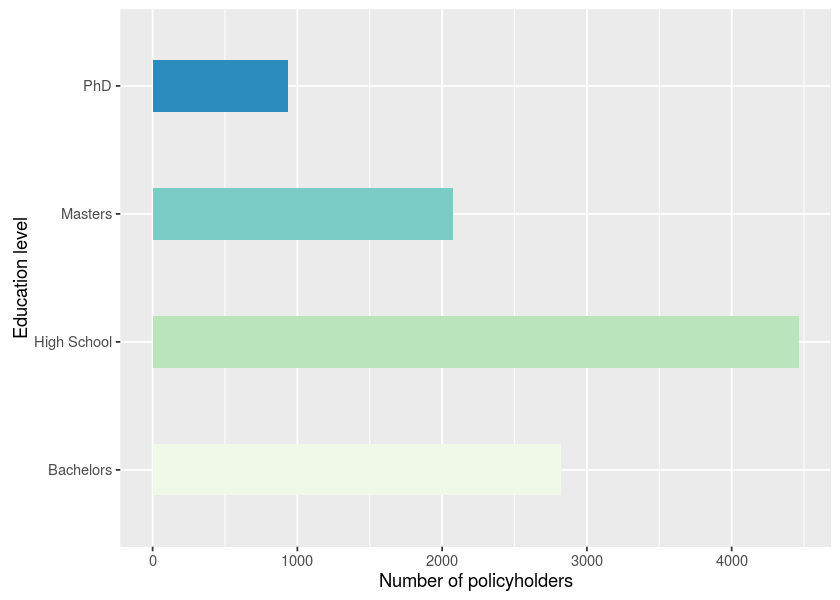

In [16]:
ggplot(data=final, aes(MAX_EDUC, fill=MAX_EDUC)) +
geom_bar(width = 0.4,show.legend=F) +
scale_fill_brewer(palette="GnBu") +
labs(x="Education level", y="Number of policyholders") +
coord_flip()

According to the above bar plot, most of our policyholders finished their education at the High School level.

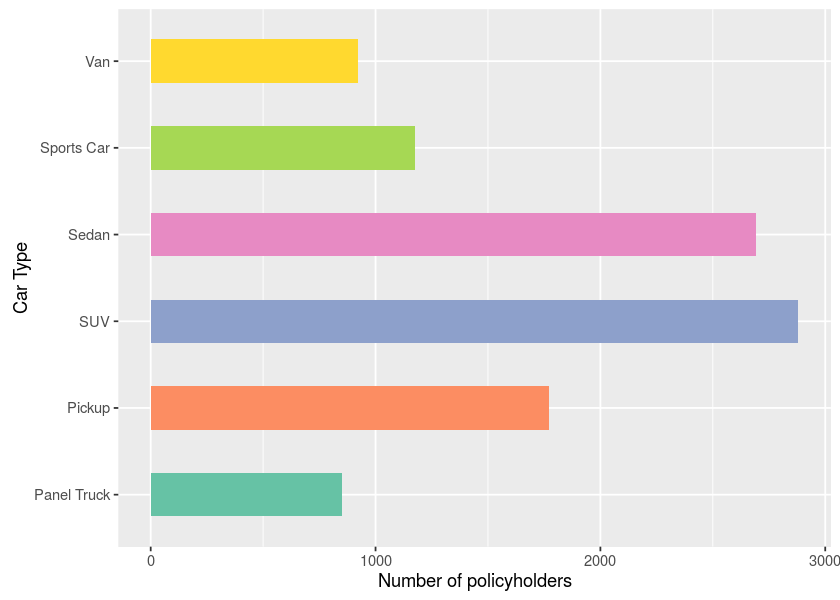

In [17]:
ggplot(data=final, aes(CAR_TYPE, fill=CAR_TYPE)) +
geom_bar(width = 0.5,show.legend=F) +
scale_fill_brewer(palette="Set2") +
labs(x="Car Type", y="Number of policyholders") +
coord_flip()

According to the plot, the majority of our policyholders owns a Sedan, SUV or Pickup car so we should create dummy variables from the CAR_TYPE variable and try incorporating them into our logistic regression models. 

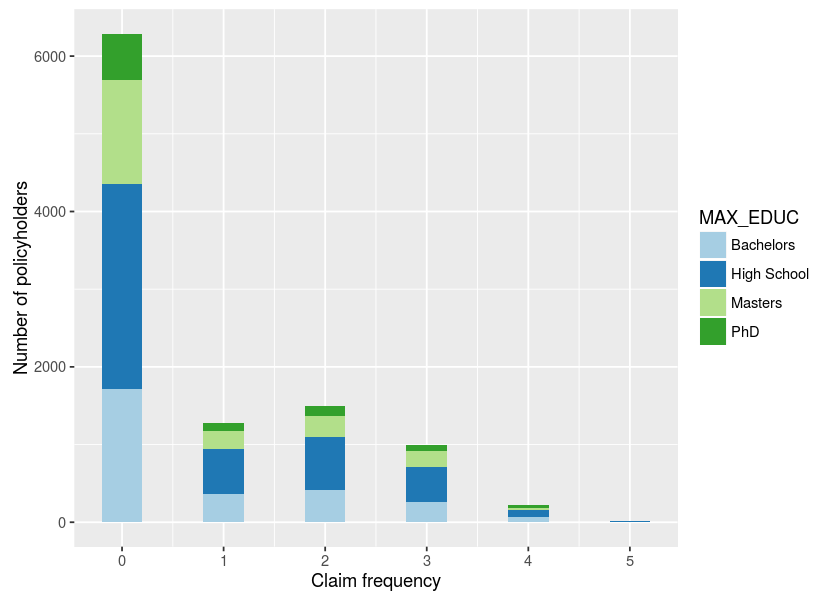

In [18]:
ggplot(data=final, aes(CLM_FREQ,fill=MAX_EDUC)) +
geom_bar(width = 0.4)+
scale_fill_brewer(palette="Paired")+
scale_x_continuous(breaks=c(0,1,2,3,4,5)) +
labs(x = "Claim frequency",y = "Number of policyholders")

According to the above bar plot, majority of our claims were submitted by drivers who ended their education at the High School level.

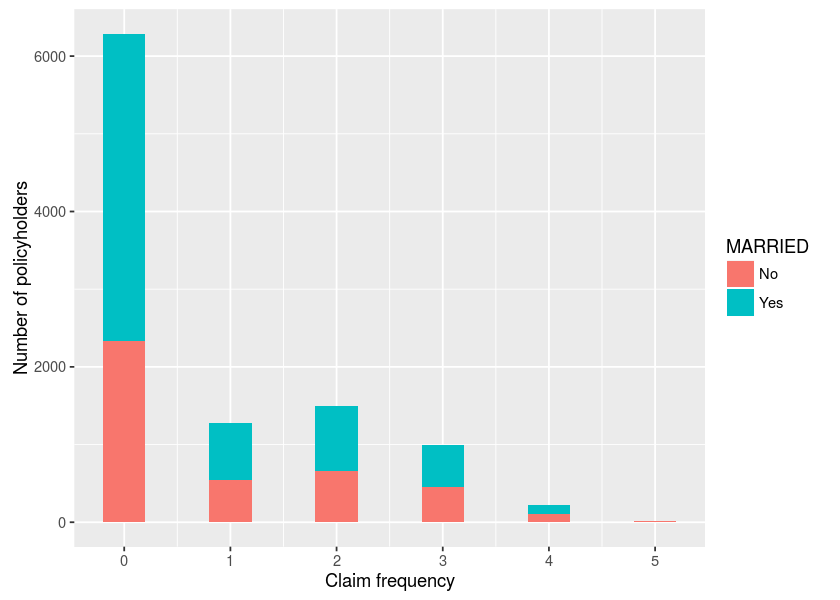

In [19]:
ggplot(data=final, aes(CLM_FREQ,fill=MARRIED)) +
geom_bar(width = 0.4)+
scale_x_continuous(breaks=c(0,1,2,3,4,5)) +
labs(x = "Claim frequency",y = "Number of policyholders")


Since most of our observations pertain to married policyholders, they also lead in the claim submission statistics, however this is not a significant ascendancy.

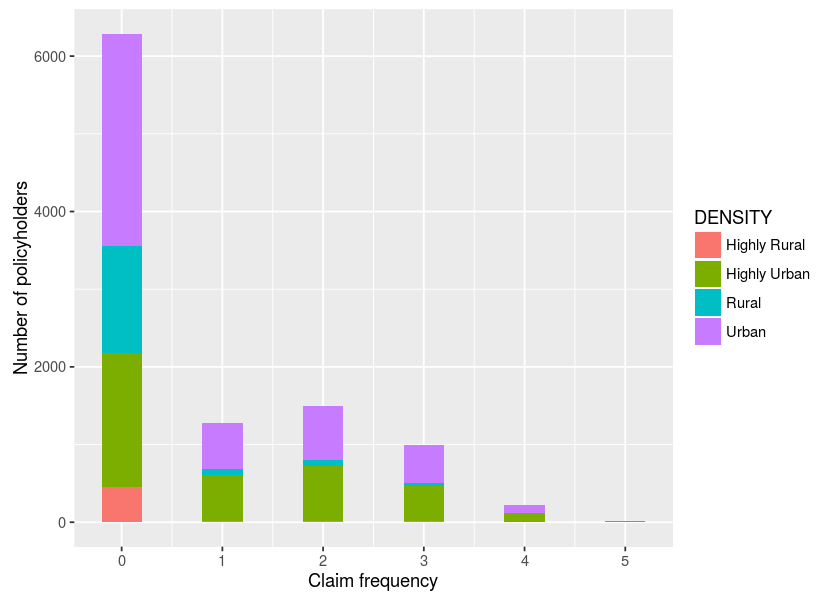

In [20]:
ggplot(data=final, aes(CLM_FREQ,fill=DENSITY)) +
geom_bar(width = 0.4)+
scale_x_continuous(breaks=c(0,1,2,3,4,5)) +
labs(x = "Claim frequency",y = "Number of policyholders")


As we could have assumed, the vast majority of claims were submitted by citizens of Urban and Highly Urban areas.

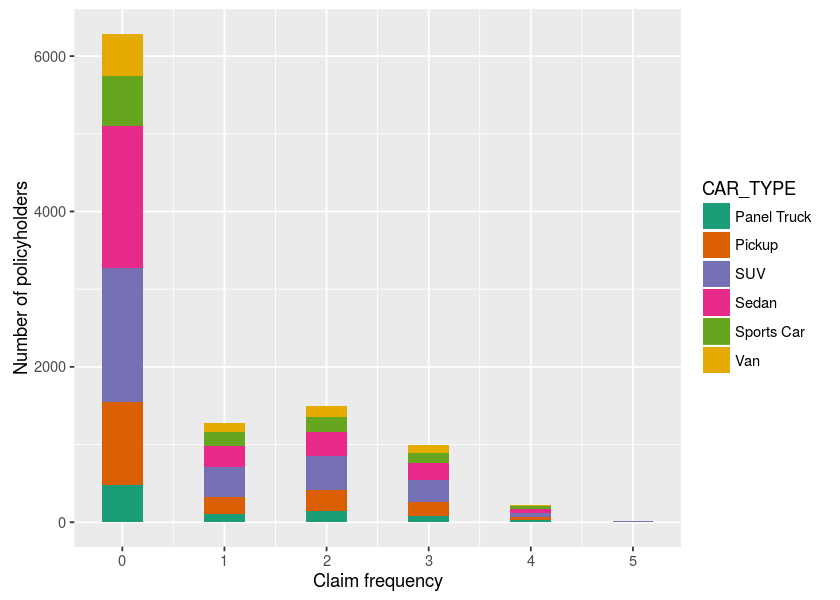

In [21]:
ggplot(data=final, aes(CLM_FREQ,fill=CAR_TYPE)) +
geom_bar(width = 0.4)+
scale_fill_brewer(palette="Dark2")+
scale_x_continuous(breaks=c(0,1,2,3,4,5)) +
labs(x = "Claim frequency",y = "Number of policyholders")


And again, as we could have assumed, Sedan, SUV and Pickup owners submitted most of the claims since they constitute to the majority of our observations.

## Correlation Heatmap

In [22]:
# Now we need to create binary variables which we will use in our logisic regression models

final$kidsdriv <- final$KIDSDRIV
final$travtime <- final$TRAVTIME
final$education <- factor(final$MAX_EDUC)
final$claim <- ifelse(final$CLM_FREQ > 0,1,0)
final$fem1624 <- ifelse (final$AGE.GENDER == '16-24F', 1, 0)
final$male1624 <- ifelse (final$AGE.GENDER == "16-24M", 1, 0)
final$fem2540 <- ifelse (final$AGE.GENDER == '25-40F', 1, 0)
final$male2540 <- ifelse (final$AGE.GENDER == '25-40M', 1, 0)
final$fem4160 <- ifelse (final$AGE.GENDER == '41-60F', 1, 0)
final$male4160 <- ifelse (final$AGE.GENDER == '41-60M', 1, 0)
final$femover60 <- ifelse(final$AGE.GENDER == '>60F',1,0)
final$maleover60 <- ifelse(final$AGE.GENDER == '>60M',1,0)
final$redcar <- ifelse(final$RED_CAR == "yes",1,0)
final$married <- ifelse(final$MARRIED == "Yes", 1,0)
final$hu <- ifelse (final$DENSITY == 'Highly Urban', 1, 0)
final$ur <- ifelse (final$DENSITY == 'Urban', 1, 0)
final$lowincome <- ifelse(final$INCOME < 29250, 1, 0)
final$mediumincome <- ifelse(final$INCOME > 29250 & final$INCOME < 53560,1,0)
final$highincome <- ifelse(final$INCOME > 53560 & final$INCOME < 83300,1,0)
final$vhighincome <- ifelse(final$INCOME > 83300 & final$INCOME < 367000,1,0)
final$commercial <- ifelse (final$CAR_USE == 'Commercial', 1, 0)
final$punishmentPTS <- final$MVR_PTS
final$sedan <- ifelse (final$CAR_TYPE == "Sedan",1,0)
final$suv <- ifelse (final$CAR_TYPE == "SUV",1,0)
final$pickup <- ifelse (final$CAR_TYPE == "Pickup",1,0)


final_ready <- final[c('travtime','kidsdriv','claim','fem1624','male1624','fem2540','male2540','fem4160','male4160','femover60','maleover60','married','lowincome','mediumincome','highincome','vhighincome','hu','ur','commercial','sedan','suv','pickup','redcar','punishmentPTS','education')]
final_ready <- dummy.data.frame(final_ready, sep=".")
final_ready <- final_ready[, !(colnames(final_ready) %in% c("education.PhD"))]

Let's take a look at the structure of our final dataset before generating a correlation matrix and starting to build a logistic regression model

In [23]:
str(final_ready)

'data.frame':	10296 obs. of  27 variables:
 $ travtime             : int  17 18 47 31 14 46 9 6 6 6 ...
 $ kidsdriv             : int  0 0 0 0 0 0 1 0 0 0 ...
 $ claim                : num  0 0 1 0 1 0 0 0 1 0 ...
 $ fem1624              : num  0 0 0 0 0 0 0 0 0 0 ...
 $ male1624             : num  0 0 0 0 0 0 0 0 0 0 ...
 $ fem2540              : num  0 0 0 0 0 1 0 0 0 0 ...
 $ male2540             : num  0 1 0 0 0 0 0 0 0 0 ...
 $ fem4160              : num  0 0 0 1 1 0 1 1 1 1 ...
 $ male4160             : num  1 0 1 0 0 0 0 0 0 0 ...
 $ femover60            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ maleover60           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ married              : num  1 0 0 1 1 1 0 0 0 0 ...
 $ lowincome            : num  0 1 0 1 0 0 0 0 0 0 ...
 $ mediumincome         : num  0 0 0 0 0 0 0 0 0 0 ...
 $ highincome           : num  1 0 0 0 0 0 0 0 0 0 ...
 $ vhighincome          : num  0 0 1 0 1 1 1 1 1 1 ...
 $ hu                   : num  1 0 0 0 0 0 1 1 1 1 ...
 $ ur           

Now let's display a correlation matrix to see what dependencies take place in our dataset

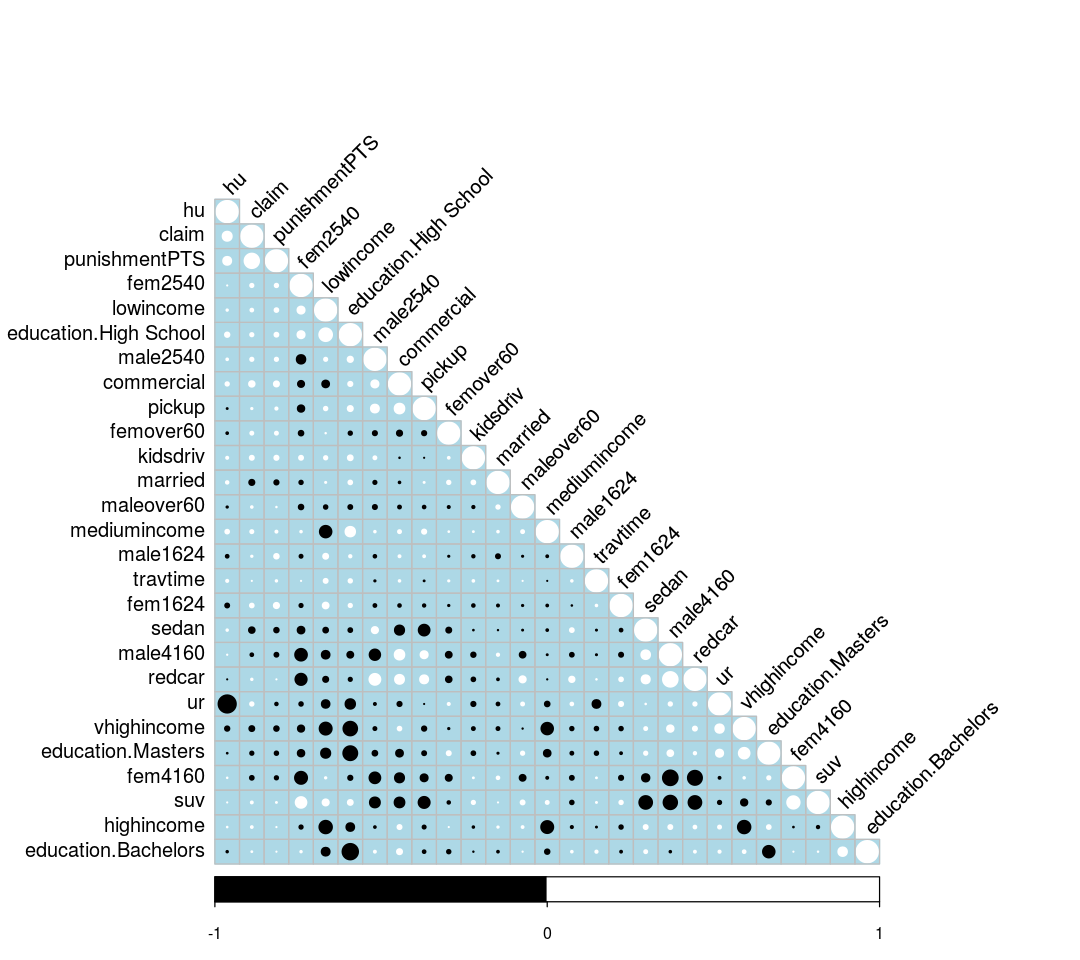

In [24]:
# Change plot size to 6 x 6
options(repr.plot.width=9, repr.plot.height=8)


corrplot(cor(final_ready),order = "hclust",addrect = 2, bg = "lightblue", type = "lower", col = c("black", "white"), 
         tl.col = "black", tl.srt = 45)

Looking at the above correlation plot enables us to derive some insights. First thing attracting our attention may be the high positive correlation between claim submission and punishment points, which makes sense, since the higher number of points the higher probability that our policyholder drives dangerously. We can also observe positive correlations between claim submissions and highly urban areas, commercial car usage, low income, medium income, High School education level, number of kids on board and some age groups like males and females between 25 and 40 years old, females over 60 years old and males and females between 16 and 24 years old.

# SPLITTING DATA INTO TRAINING AND TESTING DATASETS

The next step to perform will be dividing our dataset into the training and testing ones using "sample.split" function from "caTools" library and displaying the structure of these newly created datasets. 

In [25]:
# We need to set the so called "seed" parameter, which will enable us to receive identical data divison every time we run 
# "sample.split" function

set.seed(123)

split <- sample.split(final_ready, SplitRatio = 0.8)

training <- subset(final_ready,split=="TRUE")
testing <- subset(final_ready,split=="FALSE")


# Let's display the structure of training dataset

str(training)

'data.frame':	8008 obs. of  27 variables:
 $ travtime             : int  17 18 47 31 46 9 6 6 25 26 ...
 $ kidsdriv             : int  0 0 0 0 0 1 0 0 0 0 ...
 $ claim                : num  0 0 1 0 0 0 1 0 1 1 ...
 $ fem1624              : num  0 0 0 0 0 0 0 0 0 0 ...
 $ male1624             : num  0 0 0 0 0 0 0 0 0 0 ...
 $ fem2540              : num  0 0 0 0 1 0 0 0 0 0 ...
 $ male2540             : num  0 1 0 0 0 0 0 0 0 0 ...
 $ fem4160              : num  0 0 0 1 0 1 1 1 1 0 ...
 $ male4160             : num  1 0 1 0 0 0 0 0 0 1 ...
 $ femover60            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ maleover60           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ married              : num  1 0 0 1 1 0 0 0 1 1 ...
 $ lowincome            : num  0 1 0 1 0 0 0 0 1 0 ...
 $ mediumincome         : num  0 0 0 0 0 0 0 0 0 1 ...
 $ highincome           : num  1 0 0 0 0 0 0 0 0 0 ...
 $ vhighincome          : num  0 0 1 0 1 1 1 1 0 0 ...
 $ hu                   : num  1 0 0 0 0 1 1 1 0 1 ...
 $ ur           

Structure of testing dataset

In [26]:
str(testing)

'data.frame':	2288 obs. of  27 variables:
 $ travtime             : int  14 6 25 17 5 22 47 25 39 63 ...
 $ kidsdriv             : int  0 0 0 0 0 0 0 0 0 0 ...
 $ claim                : num  1 0 1 0 1 0 1 0 0 1 ...
 $ fem1624              : num  0 0 0 0 0 0 0 0 0 0 ...
 $ male1624             : num  0 0 0 0 0 0 0 0 0 0 ...
 $ fem2540              : num  0 0 0 0 1 0 0 0 1 0 ...
 $ male2540             : num  0 0 0 0 0 0 0 0 0 0 ...
 $ fem4160              : num  1 1 1 1 0 0 1 0 0 1 ...
 $ male4160             : num  0 0 0 0 0 1 0 1 0 0 ...
 $ femover60            : num  0 0 0 0 0 0 0 0 0 0 ...
 $ maleover60           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ married              : num  1 0 1 1 0 1 0 1 0 0 ...
 $ lowincome            : num  0 0 1 0 0 1 1 0 0 1 ...
 $ mediumincome         : num  0 0 0 0 1 0 0 1 1 0 ...
 $ highincome           : num  0 0 0 1 0 0 0 0 0 0 ...
 $ vhighincome          : num  1 1 0 0 0 0 0 0 0 0 ...
 $ hu                   : num  0 1 0 0 0 0 0 0 0 1 ...
 $ ur          

# POISSON MODEL

Now we will build 2 classification models using Poisson distribution. First model will consist only of the intercept while the second one will have all features available in the training and testing datasets. This is due to the fact that we are going to utilize the "step" procedure with the "forward" method which will choose the most significant features for us by iterating over available variables and adding the most significant ones to the intercept based on minimazing the Akaike criterion.  

It's worth mentioning that the "Step" procedure is not the only possible way of finding the most significat variables, we could also use "Lasso" procedure which is available in R's "glmnet" library.  

In [27]:
# Model with intercept only

poisson_model_null <-  glm(claim ~ 1, data = training, family="poisson")

# Model with all possible features

poisson_model_full <- glm(claim ~ ., data = training, family='poisson')

# Running the "step" procedure

step_model_logitv1 <- step(poisson_model_null,scope = list(lower = poisson_model_null, upper=poisson_model_full), direction = "forward")

Start:  AIC=12080.34
claim ~ 1

                          Df Deviance   AIC
+ punishmentPTS            1   5018.0 11216
+ hu                       1   5711.4 11909
+ sedan                    1   5851.8 12050
+ vhighincome              1   5853.0 12051
+ married                  1   5853.7 12052
+ commercial               1   5854.3 12052
+ fem4160                  1   5869.6 12068
+ kidsdriv                 1   5874.4 12072
+ ur                       1   5876.2 12074
+ `education.High School`  1   5877.2 12075
+ fem2540                  1   5878.2 12076
+ mediumincome             1   5878.4 12076
+ education.Masters        1   5878.6 12077
+ male2540                 1   5879.0 12077
+ fem1624                  1   5879.4 12077
+ femover60                1   5880.6 12079
+ highincome               1   5880.7 12079
<none>                         5884.3 12080
+ redcar                   1   5882.5 12080
+ suv                      1   5882.9 12081
+ lowincome                1   5883.1 12081


The next vital step will be prediction of claim submission on the training dataset, choosing the best possible cut-off point for the ROC curve, creation of confusion matrix, calculation the area under ROC curve and displying it. Since this step will be repeated for logit and probit models as well, I decided to create a function. 

# INSTANTIATING MODEL CREATION FUNCTION

In [28]:
# The below created function will require 3 parameters : dataset, parameters and label. It will print out the model 
# statistics, choose the best possible cut-off point(threshold), display the ROC curve and calculate the prediction 
# accuracy and area under the curve

model <- function(dataset,parameters,label){
  
  full_model <- parameters
  
  prob <- predict(full_model,dataset,type="response")
  ROCRPred = prediction(prob,label)
  ROCRPref = performance(ROCRPred, "tpr", "fpr")
  my_roc <- roc(label, prob)
  best_threshold <- coords(my_roc, "best", ret="threshold")
  accuracy <- coords(my_roc,"best",ret="accuracy")
  auc <- auc(my_roc)
    
 # Creation of confusion matrix 
    
  table <- table(ActualValue = label, PredictedValue = prob > best_threshold)
  
 # Displaying the calculated statistics and ROC curve   
    
  print(summary(full_model))
  cat("\n")
  print(paste("The best threshold is: ",round(best_threshold,digits = 2), sep="")) 
  print(paste("Models accuracy is: ", round(accuracy*100, digits = 2),"%", sep= ""))
  cat("\n")
  print(table)
  plot(my_roc, col="red")
  
}


# POISSON MODEL ON TRAINING DATA SET


Call:
glm(formula = claim ~ punishmentPTS + hu + ur + vhighincome + 
    sedan + married + commercial + kidsdriv + pickup + fem4160 + 
    `education.High School`, family = poisson, data = dataset)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7641  -0.7809  -0.4725   0.4899   1.9474  

Coefficients:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)             -2.280460   0.086791 -26.275  < 2e-16 ***
punishmentPTS            0.169227   0.006726  25.159  < 2e-16 ***
hu                       1.273696   0.078753  16.173  < 2e-16 ***
ur                       1.184764   0.078717  15.051  < 2e-16 ***
vhighincome             -0.223926   0.048899  -4.579 4.66e-06 ***
sedan                   -0.191602   0.046306  -4.138 3.51e-05 ***
married                 -0.141561   0.036353  -3.894 9.86e-05 ***
commercial               0.108881   0.038823   2.805  0.00504 ** 
kidsdriv                 0.091035   0.032484   2.802  0.00507 ** 
pickup      

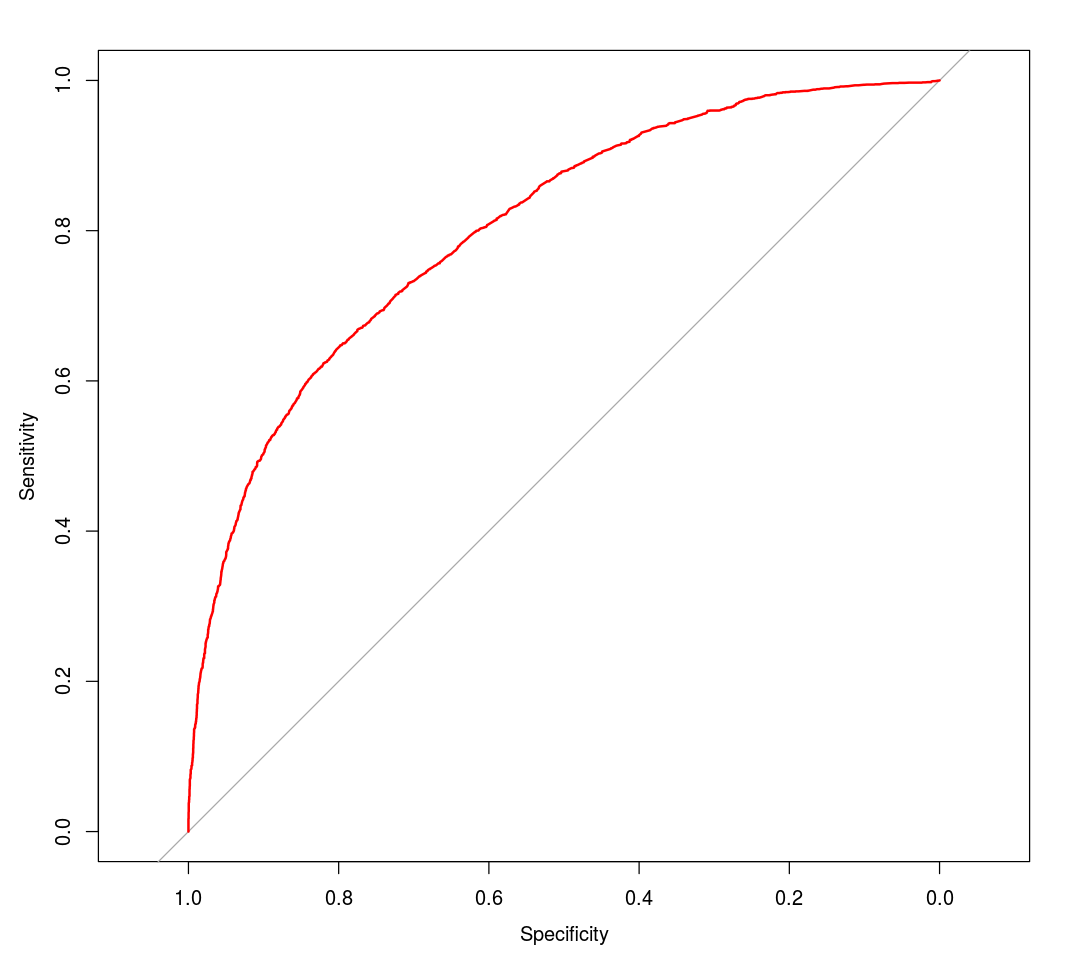

In [29]:
# Here, we need to declare which dataset we want to use for training our model.

dataset = training

# For parameters variable we are going to declare the final model(features) chosen by the "step" procedure


parameters <- glm(claim ~ punishmentPTS + hu + ur + vhighincome + sedan + married + 
    commercial + kidsdriv + pickup + fem4160 + `education.High School`, data=dataset, family=poisson)


label = training$claim

# Let's run our "model" function with the above parameters

model(dataset,parameters,label)


According to the above statistics, Poisson distribution based model predicted 73.96% of claim submission correctly on the training dataset. Now, let's see how it will perform on the previously unseen data from the testing dataset. 

# POISSON MODEL ON TESTING DATA SET


Call:
glm(formula = claim ~ punishmentPTS + hu + ur + vhighincome + 
    sedan + married + commercial + kidsdriv + pickup + fem4160 + 
    `education.High School`, family = poisson, data = dataset)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7869  -0.7853  -0.4982   0.5046   1.7514  

Coefficients:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             -2.12171    0.15175 -13.981  < 2e-16 ***
punishmentPTS            0.18033    0.01215  14.844  < 2e-16 ***
hu                       1.11613    0.13731   8.128 4.35e-16 ***
ur                       0.95361    0.13816   6.902 5.12e-12 ***
vhighincome             -0.09819    0.08608  -1.141    0.254    
sedan                   -0.19356    0.08754  -2.211    0.027 *  
married                 -0.10382    0.06766  -1.534    0.125    
commercial               0.09551    0.07313   1.306    0.192    
kidsdriv                 0.05689    0.05942   0.957    0.338    
pickup                

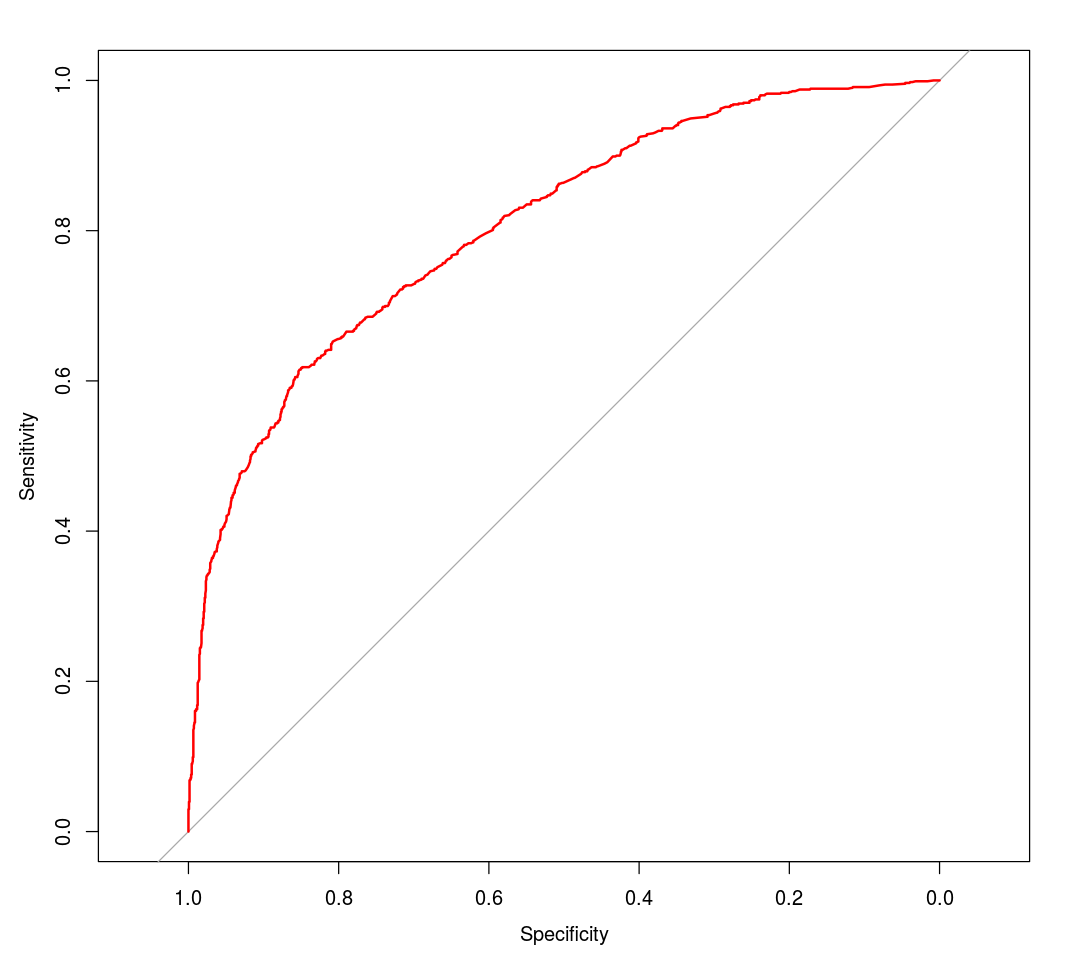

In [30]:
dataset = testing

parameters <- glm(claim ~ punishmentPTS + hu + ur + vhighincome + sedan + married + 
    commercial + kidsdriv + pickup + fem4160 + `education.High School`, data=dataset, family=poisson)

label = testing$claim

model(dataset,parameters,label)

It is surprising that predicting the value of the explained variable on the testing dataset resulted in Poisson distribution based model with the accuracy of 75.74%, which is better than on the training dataset. We also received much lower values of the Akaike criterion and lower residual deviance. Also, according to our statistics, we can see that in this case, there are only 4 statistically significant variables except intercept: punishment points, urban and highly urban areas and sedan car type. The lower number of features helps our model to generalize from training into the testing datasets more easily. This might be the reason why we received better results. It's worth pointing out, that this dataset is good for learning, but too small for making real business decisions. 


Now let's try to estimate the effectiveness of the logistic regression model based on binomial distribution and using "logit" link function. This time, we will skip using the "step" procedure to select the best explanatory variables and use the same variables as for the Poisson distribution based model to be able to compare their results.

# LOGIT MODEL ON TRAINING DATA SET


Call:
glm(formula = claim ~ punishmentPTS + hu + ur + vhighincome + 
    sedan + married + commercial + kidsdriv + pickup + fem4160 + 
    `education.High School`, family = binomial, data = dataset)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.6965  -0.8063  -0.4186   0.8239   2.7731  

Coefficients:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             -2.64064    0.11282 -23.406  < 2e-16 ***
punishmentPTS            0.49686    0.01505  33.020  < 2e-16 ***
hu                       2.01998    0.09592  21.059  < 2e-16 ***
ur                       1.81746    0.09541  19.050  < 2e-16 ***
vhighincome             -0.44543    0.07002  -6.361 2.00e-10 ***
sedan                   -0.41320    0.06743  -6.128 8.89e-10 ***
married                 -0.32406    0.05560  -5.828 5.59e-09 ***
commercial               0.26213    0.05985   4.380 1.19e-05 ***
kidsdriv                 0.21987    0.05468   4.021 5.79e-05 ***
pickup               

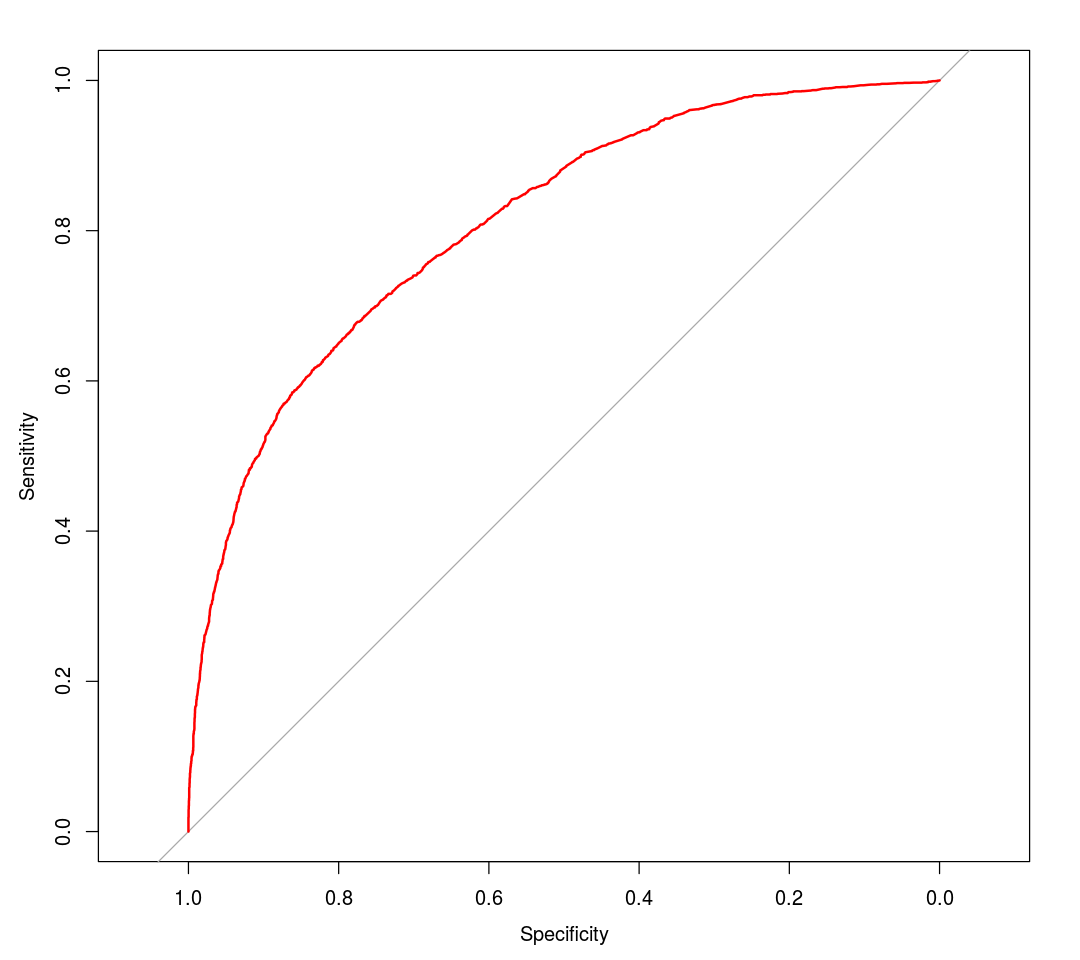

In [31]:
dataset = training

parameters <- glm(claim ~ punishmentPTS + hu + ur + vhighincome + sedan + married + 
    commercial + kidsdriv + pickup + fem4160 + `education.High School`, data=dataset, family=binomial)

label = training$claim

model(dataset,parameters,label)

As we can see, the above model achieves similar results to the Poisson model based on training dataset. The Akaike criterion equals to 8149.5 compared to 10808 for the Poisson model. Also, the accuracy of the estimates of the dependent variable is similar. Let's see how our logit model will perform on the testing dataset, whether this time we will be able to beat the previously set record or not.

# LOGIT MODEL ON TESTING DATA SET


Call:
glm(formula = claim ~ punishmentPTS + hu + ur + vhighincome + 
    sedan + married + commercial + kidsdriv + pickup + fem4160 + 
    `education.High School`, family = binomial, data = dataset)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8052  -0.7986  -0.4055   0.7913   2.5445  

Coefficients:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             -2.47632    0.20507 -12.075  < 2e-16 ***
punishmentPTS            0.57101    0.03007  18.988  < 2e-16 ***
hu                       1.91274    0.17396  10.995  < 2e-16 ***
ur                       1.47907    0.17322   8.538  < 2e-16 ***
vhighincome             -0.28627    0.12920  -2.216  0.02671 *  
sedan                   -0.41142    0.12971  -3.172  0.00151 ** 
married                 -0.26828    0.10531  -2.547  0.01085 *  
commercial               0.19321    0.11476   1.684  0.09228 .  
kidsdriv                 0.07564    0.09965   0.759  0.44779    
pickup               

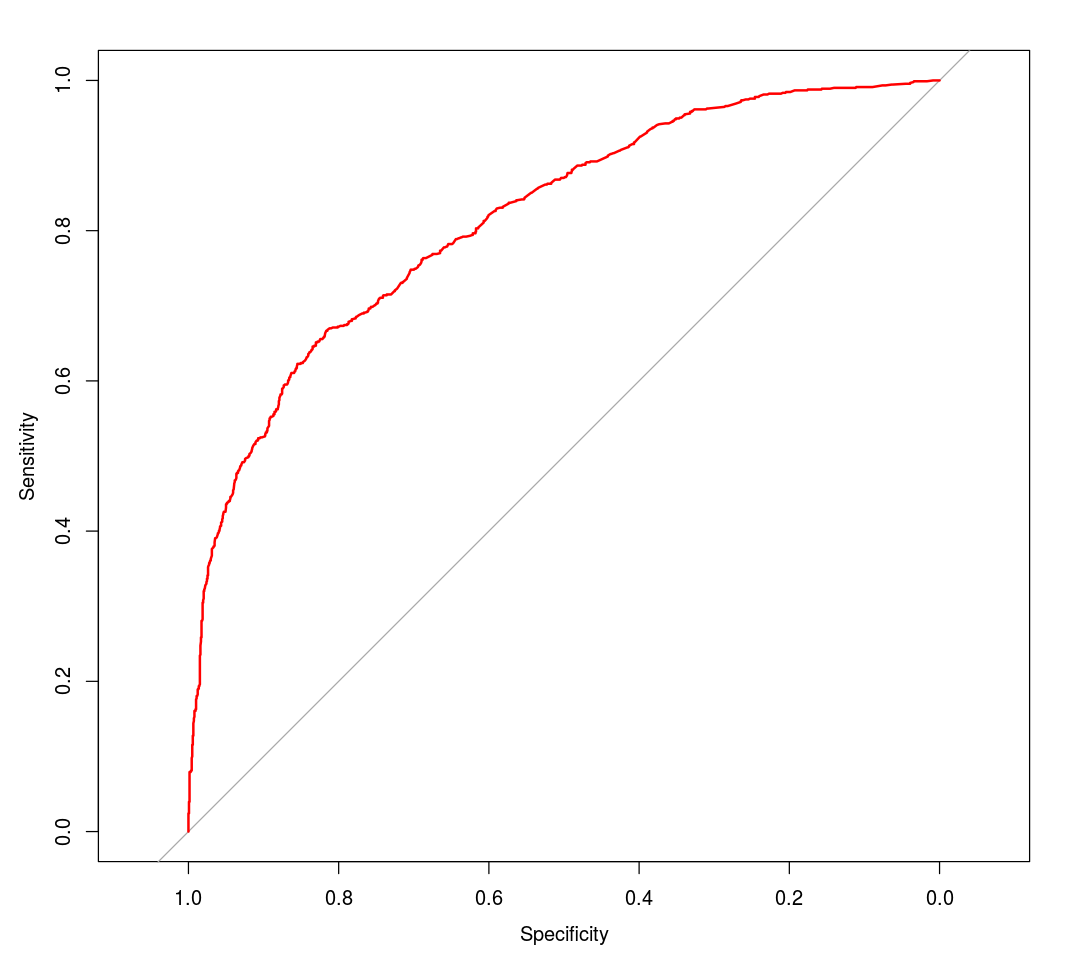

In [32]:
dataset = testing

parameters <- glm(claim ~ punishmentPTS + hu + ur + vhighincome + sedan + married + 
    commercial + kidsdriv + pickup + fem4160 + `education.High School`, data=dataset, family=binomial)

label = testing$claim

model(dataset,parameters,label)

As we can observe, the prediction on the testing dataset achieves better results than the prediction on the training dataset. Logistic regression with the "logit" binding function achieves slightly weaker estimation accuracy - 75.7% - than the Poisson model on the testing dataset - 75.74%, however the Akaike criterion is better as it equals to 2321.1 compared to the 3154 for Poisson model. 


Finally, let's check what will be the effectiveness of the logistic regression model with the "probit" link function.

# PROBIT MODEL ON TRAINING DATA SET


Call:
glm(formula = claim ~ punishmentPTS + hu + ur + vhighincome + 
    sedan + married + commercial + kidsdriv + pickup + fem4160 + 
    `education.High School`, family = binomial(link = "probit"), 
    data = dataset)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8612  -0.8142  -0.4101   0.8405   2.9509  

Coefficients:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)             -1.539118   0.062234 -24.731  < 2e-16 ***
punishmentPTS            0.295241   0.008513  34.682  < 2e-16 ***
hu                       1.159068   0.052399  22.120  < 2e-16 ***
ur                       1.041108   0.051901  20.060  < 2e-16 ***
vhighincome             -0.260205   0.041042  -6.340 2.30e-10 ***
sedan                   -0.245009   0.039401  -6.218 5.02e-10 ***
married                 -0.186208   0.032663  -5.701 1.19e-08 ***
commercial               0.148728   0.035183   4.227 2.37e-05 ***
kidsdriv                 0.128289   0.032061   4.001 6.

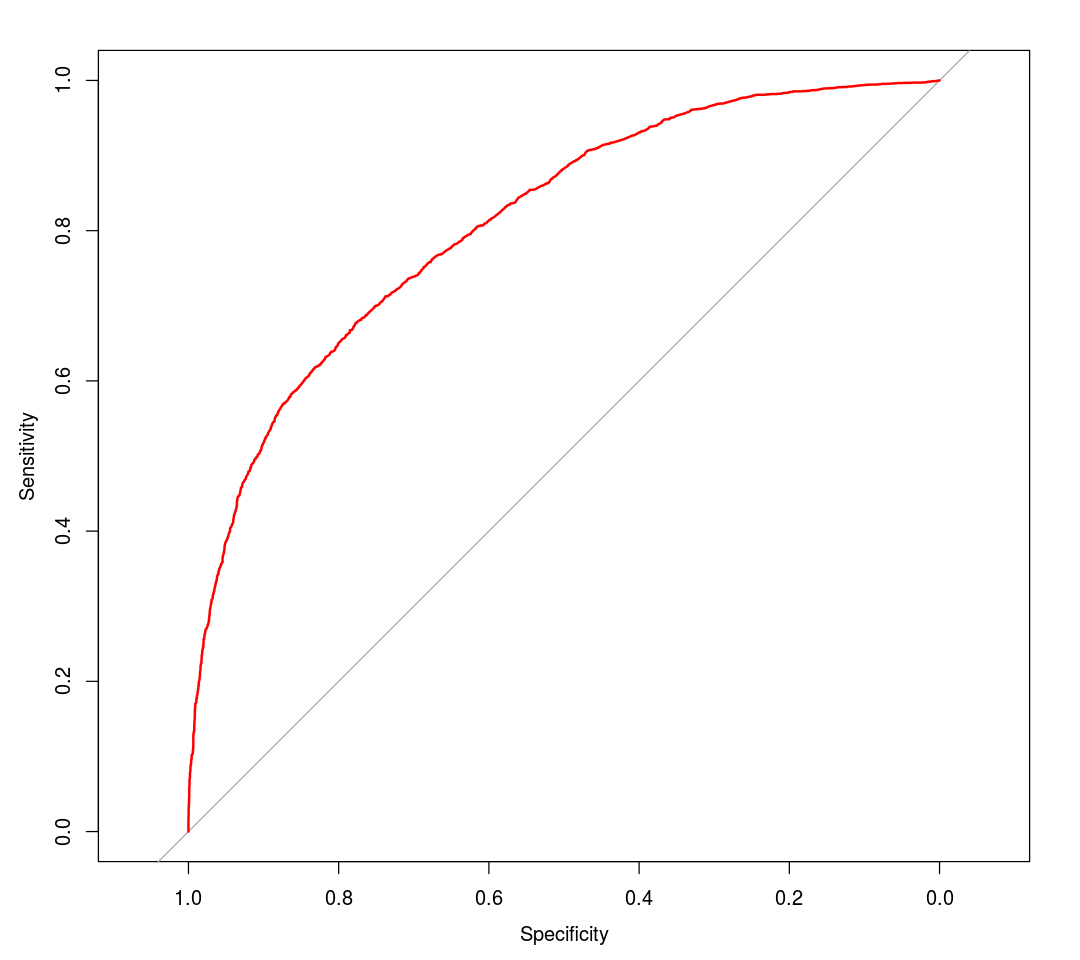

In [33]:
dataset = training

parameters <- glm(claim ~ punishmentPTS + hu + ur + vhighincome + sedan + married + 
    commercial + kidsdriv + pickup + fem4160 + `education.High School`, data=dataset, family=binomial(link="probit"))

label = training$claim

model(dataset,parameters,label)


The logistic regression model with the "probit" link function for the applied set of explanatory variables achieves the prediction accuracy similar to the Poisson model and the logistic regression model with the "logit" link function. At the very end, let's check how our "probit" model performs on the testing dataset.

# PROBIT MODEL ON TESTING DATA SET


Call:
glm(formula = claim ~ punishmentPTS + hu + ur + vhighincome + 
    sedan + married + commercial + kidsdriv + pickup + fem4160 + 
    `education.High School`, family = binomial(link = "probit"), 
    data = dataset)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.0018  -0.8077  -0.3947   0.8105   2.6288  

Coefficients:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             -1.45004    0.11376 -12.747  < 2e-16 ***
punishmentPTS            0.33607    0.01677  20.035  < 2e-16 ***
hu                       1.09920    0.09559  11.499  < 2e-16 ***
ur                       0.85149    0.09500   8.963  < 2e-16 ***
vhighincome             -0.16665    0.07579  -2.199  0.02788 *  
sedan                   -0.23698    0.07533  -3.146  0.00165 ** 
married                 -0.14994    0.06169  -2.431  0.01508 *  
commercial               0.11059    0.06738   1.641  0.10076    
kidsdriv                 0.03821    0.05863   0.652  0.51461    

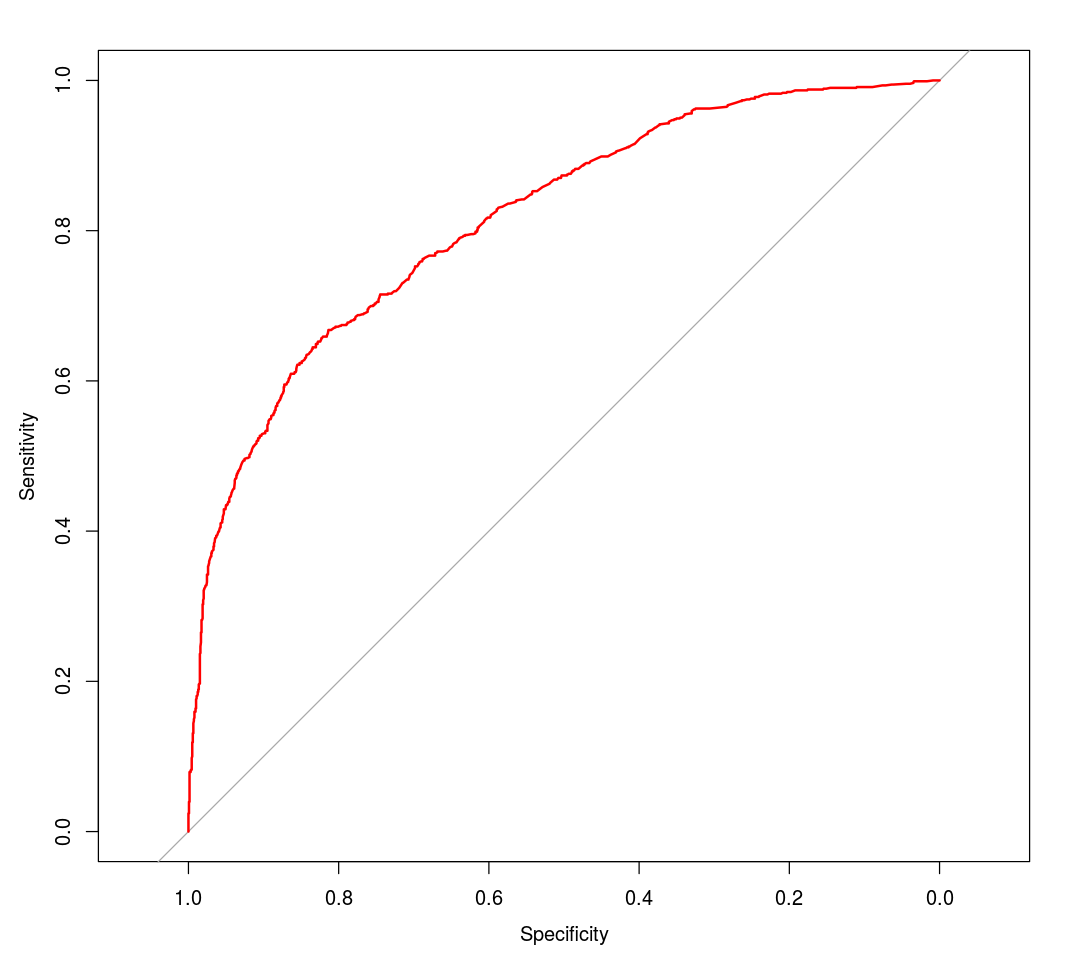

In [34]:
dataset = testing

parameters <- glm(claim ~ punishmentPTS + hu + ur + vhighincome + sedan + married + 
    commercial + kidsdriv + pickup + fem4160 + `education.High School`, data=dataset, family=binomial(link="probit"))

label = testing$claim

model(dataset,parameters,label)


According to the model summaries we have built so far, we achieved the best value of the Akaike criterion for the logistic regression model using "logit" link function and based on binomial distribution, however, the best prediction accuracy was scored by the logistic regression model based on Poisson distribution. As I mentioned previously, to derive more accurate insights, we should work on the datasets which constists of much more observations since logistic regression models are efficiently handling the vast amounts of data. If we had dozens or hundreds of features we could use Lasso regression to help us choose the best explanatory variables by applying L1 regularization.